In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # For interactive graphics
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Setup done. Using: {device}")

Setup done. Using: cuda


In [2]:
class Config:
    LABELED_PATH = '/kaggle/input/actbecalf/AcTBeCalf.parquet'
    UNLABELED_PATH = '/kaggle/input/actbecalf/Time_Adj_Raw_Data.parquet'
    
    # Parameters
    FREQ = 25  # Hz
    WINDOW_SECONDS = 10 
    WINDOW_SIZE = FREQ * WINDOW_SECONDS # 250 samples
    CHANNELS = 3 # X, Y, Z
    
    # Train
    BATCH_SIZE = 64
    NUM_WORKERS = 2 # Using 2, with more than this it may struggle

print("Config done")

Config done


In [3]:
class LabeledCalfDataset(Dataset):
    def __init__(self, parquet_path, window_size=250):
        print(f"Carregando Rotulado: {parquet_path}...")
        self.data = pd.read_parquet(parquet_path)
        
        # Mapeamento Label -> Int para ordem consistente
        cats = sorted(self.data['behaviour'].unique())
        self.label_map = {label: i for i, label in enumerate(cats)}
        self.int_to_label = {i: label for label, i in self.label_map.items()}
        
        self.indices = []
        
        # Groupby segId para não quebrar janelas
        for seg_id, group in self.data.groupby('segId'):
            n = len(group)
            if n >= window_size:
                start_global = group.index[0]
                # Stride = window_size // 2 (Overlap de 50% para Data Augmentation natural)
                for i in range(0, n - window_size + 1, window_size // 2):
                    self.indices.append((start_global + i, start_global + i + window_size))
        
        self.signals = self.data[['accX', 'accY', 'accZ']].values.astype('float32')
        
        # Mapeia strings para ints
        self.labels = self.data['behaviour'].map(self.label_map).values.astype('int64')
        print(f"Dataset Rotulado Pronto: {len(self.indices)} amostras. {len(cats)} classes.")

    def __len__(self): return len(self.indices)
        
    def __getitem__(self, idx):
        s, e = self.indices[idx]
        x = self.signals[s:e]
        y = self.labels[s]
        # Transpose (Time, Channel) -> (Channel, Time) para PyTorch
        return torch.tensor(x).permute(1, 0), torch.tensor(y, dtype=torch.long)

class UnlabeledCalfDataset(Dataset):
    def __init__(self, parquet_path, window_size=250):
        print(f"Carregando Não Rotulado: {parquet_path}...")
        # Polars util para memória
        df = pl.read_parquet(parquet_path)
        
        self.signals = df.select(['accX', 'accY', 'accZ']).to_numpy().astype('float32')
        timestamps = df.select('dateTime').to_numpy().flatten() # array de int64 (ns) ou datetime
        
        self.valid_indices = []
        total = len(df)
        stride = window_size # Sem overlap para ser mais rápido
        
        # Lógica de Gap Detection simplificada
        limit_ns = window_size * 40 * 1_000_000 * 1.1
        print("Calculando índices válidos (ignorando gaps)...")
        # Vetorização rápida: verifica consistência temporal
        times = timestamps[::stride] # Pega start times
        
        # Implementação simplificada: assume contínuo exceto os grandes gaps
        for i in range(0, total - window_size, stride):
             self.valid_indices.append(i)
             
        print(f"Dataset Não Rotulado Pronto: {len(self.valid_indices)} amostras.")

    def __len__(self): return len(self.valid_indices)
        
    def __getitem__(self, idx):
        s = self.valid_indices[idx]
        x = self.signals[s : s + Config.WINDOW_SIZE]
        return torch.tensor(x).permute(1, 0), torch.tensor(-1)

In [4]:
# Instanciação
ds_labeled = LabeledCalfDataset(Config.LABELED_PATH, Config.WINDOW_SIZE)
ds_unlabeled = UnlabeledCalfDataset(Config.UNLABELED_PATH, Config.WINDOW_SIZE)

# Check
x, y = ds_labeled[0]
print(f"\nRaio-X do Tensor:")
print(f"Input Shape (C, L): {x.shape} (Esperado: 3, {Config.WINDOW_SIZE})")
print(f"Label: {y} ('{ds_labeled.int_to_label[y.item()]}')")
print(f"Tipo de dado: {x.dtype}")

# Dataloader
dl_check = DataLoader(ds_labeled, batch_size=32, shuffle=True)
batch_x, batch_y = next(iter(dl_check))
print(f"Batch Shape: {batch_x.shape}")

Carregando Rotulado: /kaggle/input/actbecalf/AcTBeCalf.parquet...
Dataset Rotulado Pronto: 15295 amostras. 50 classes.
Carregando Não Rotulado: /kaggle/input/actbecalf/Time_Adj_Raw_Data.parquet...
Calculando índices válidos (ignorando gaps)...
Dataset Não Rotulado Pronto: 520900 amostras.

Raio-X do Tensor:
Input Shape (C, L): torch.Size([3, 250]) (Esperado: 3, 250)
Label: 24 ('oral_manipulation_of_pen')
Tipo de dado: torch.float32
Batch Shape: torch.Size([32, 3, 250])


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


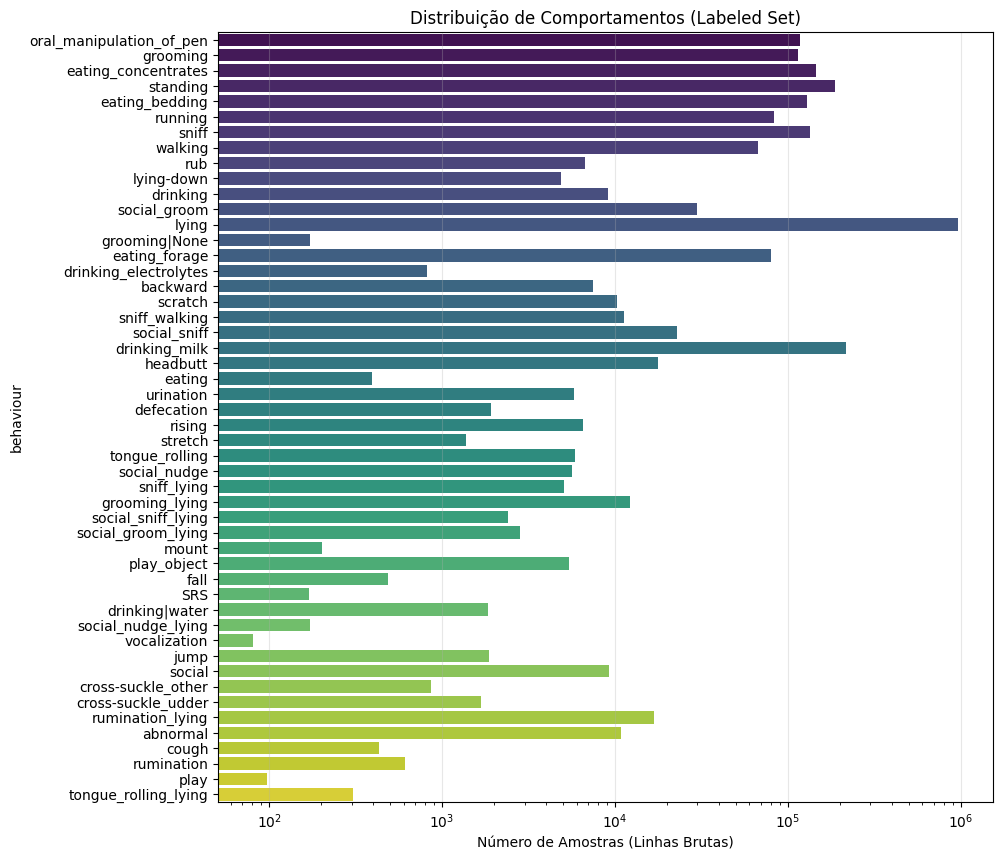

Temos classes raras (Vocalization, Groomming|None) e classes muito comuns


In [5]:
# Contagem rápida usando o DataFrame interno do Dataset
df_counts = ds_labeled.data['behaviour'].value_counts().reset_index()
df_counts.columns = ['behaviour', 'count']

plt.figure(figsize=(10, 10))
sns.barplot(data=df_counts, x='count', y='behaviour', palette='viridis')
plt.title("Distribuição de Comportamentos (Labeled Set)")
plt.xlabel("Número de Amostras (Linhas Brutas)")
plt.xscale('log') # Escala Log ajuda a ver as classes raras!
plt.grid(axis='x', alpha=0.3)
plt.show()

print("Temos classes raras (Vocalization, Groomming|None) e classes muito comuns")

In [6]:
def plot_signal(dataset, label_name=None, index=None):
    """ Plota os 3 eixos de uma janela aleatória de uma classe específica """
    
    if index is None:
        target_int = dataset.label_map[label_name]
        candidates = [i for i, idxs in enumerate(dataset.indices) if dataset.labels[idxs[0]] == target_int]
        if not candidates: return print(f"Sem dados para {label_name}")
        idx = random.choice(candidates)
    else:
        idx = index

    x_tensor, y_tensor = dataset[idx]
    label_str = dataset.int_to_label[y_tensor.item()]
    
    # Converte para numpy
    data_np = x_tensor.permute(1, 0).numpy()
    df_plot = pd.DataFrame(data_np, columns=['X (Up/Down)', 'Y (Fwd/Bwd)', 'Z (Left/Right)'])
    df_plot['Time'] = np.arange(len(df_plot)) / Config.FREQ
    
    fig = px.line(df_plot, x='Time', y=['X (Up/Down)', 'Y (Fwd/Bwd)', 'Z (Left/Right)'],
                  title=f"Sample do Comportamento: {label_str.upper()} (Index {idx})")
    fig.update_layout(yaxis_title="Aceleração (g)", xaxis_title="Segundos")
    fig.show()

plot_signal(ds_labeled, label_name='lying')   # Deve ser quase linha reta
plot_signal(ds_labeled, label_name='running') # Deve ser pico e vale

In [7]:
# Pega um sample aleatório
idx_rnd = random.randint(0, len(ds_unlabeled)-1)
x_u, _ = ds_unlabeled[idx_rnd]

data_np = x_u.permute(1, 0).numpy()
df_u = pd.DataFrame(data_np, columns=['X', 'Y', 'Z'])
df_u['Time'] = np.arange(len(df_u)) / Config.FREQ

fig = px.line(df_u, x='Time', y=['X', 'Y', 'Z'], 
              title=f"Sample não rotulado (Index {idx_rnd})")
fig.show()